# Run each scheme

Using this Notebook to test the module, so using IPy extension `autoreload`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

/usr/local/miniconda3/envs/py3d/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%matplotlib notebook

## Test module import

In [3]:
import sys
sys.path.append('../')

In [4]:
%load_ext autoreload
%autoreload 1
%aimport crt1d

scheme IDs available: bl, 2s, 4s, zq, bf, gd
looking for necessary model input data in
    /Users/zmoon/gh/1D-canopy-rad/crt1d/data


In [5]:
import crt1d as crt

In [6]:
crt.model

crt1d.crt1d.model

In [7]:
import inspect
inspect.getfullargspec(crt.solvers.bl.solve_bl)

FullArgSpec(args=[], varargs=None, varkw=None, defaults=None, kwonlyargs=['psi', 'I_dr0_all', 'I_df0_all', 'wl', 'dwl', 'lai', 'leaf_t', 'leaf_r', 'green', 'K_b_fn'], kwonlydefaults=None, annotations={})

In [8]:
df_schemes = pd.DataFrame(crt.available_schemes).T

BL_args = set(a for a in df_schemes.loc[df_schemes.ID == 'bl'].args[0])
df_schemes['args_minus_BL'] = df_schemes['args'].apply(lambda x: set(x).symmetric_difference(BL_args))

df_schemes.drop(columns=['args', 'solver'])  # solver memory address not very informative

,module_name,ID,short_name,long_name,args_minus_BL
bl,bl,bl,B-L,Beer-Lambert,{}
2s,twos_ds,2s,2s,Dickinson–Sellers two-stream,"{G_fn, soil_r, mean_leaf_angle}"
4s,fours,4s,4s,four-stream,"{mu_s, G_fn, soil_r}"
zq,zq,zq,ZQ,Zhao & Qualls multi-scattering,"{G_fn, soil_r}"
bf,bf,bf,BF,Bodin & Franklin improved Goudriaan,{soil_r}
gd,gd,gd,Gou,Goudriaan,{soil_r}


## Test running

In [9]:
#schemes_to_test = ['bl', 'bf', '2s']
#schemes_to_test = ['2s']
schemes_to_test = ['bf']

mi = dict(\
    wl=np.r_[0.55, 1.0], dwl=np.r_[0.3, 2], 
    leaf_r=np.r_[0.04, 0.05], leaf_t=np.r_[0.17, 0.23], soil_r=np.r_[0.2, 0.2],
    I_df0=np.r_[1000, 100][np.newaxis,:], I_dr0=np.r_[5000, 500][np.newaxis,:],
    )
 

for scheme_ID in schemes_to_test:
    m = crt.model(scheme_ID, mi=mi, nlayers=10)
    m.run()






scheme: bf
----------------------------------------

LAI vertical profile not provided. Using sample Gamma.

`green' not provided. Using default.

`mean_leaf_angle' not provided. Using default.

`clump' not provided. Using default.


----------------------------------------
now running the model...

it: 0
2 sh: [5.74451404 4.83633952 4.45592999 4.47072311 4.76488738 5.19984555
 5.55496096 5.42756242 4.05590012]
3 sh: [ 66.8242691   75.38261974  87.56726619 102.6221465  119.19698923
 134.67688047 144.06297682 138.07905898  99.95915377]
incoming : 1800.0
upwelling: 214.3991144251892
in-upwell: 1585.6008855748107
in-upwell-grnd: 1434.6137376615825
in-blwcnpy: 1611.2660651084648

leaf abs??: 4559.840546127471
leaf abs???: 1778.5789957116044
leaf abs?: 1405.0774066121676
leaf abs?: 1698.0470461290327
leaf abs0: 458.7740397568966
leaf abs1: 856.137857942118
leaf abs2: 982.8232383426111
leaf abs2:
leaf abs3: 1612.991078572268
leaf abs4: 730.7259645792748
cnpy abs?: 1597.6824205624403
leaf 

<IPython.core.display.Javascript object>


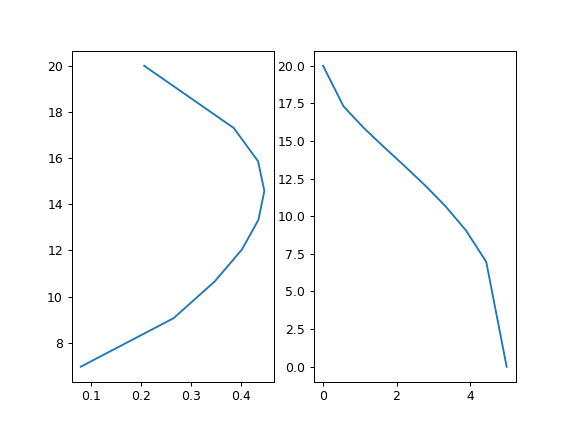

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2)

ax1.plot(-np.diff(m.lai)/np.diff(m.z), m.z[1:])
ax2.plot(m.lai, m.z)


In [11]:
"""
iwl = 0

upwelling = m.I_df_u[0, -1, :]
incoming = (m.I_df0 + m.I_dr0)*m.dwl
tot_absorbed = incoming-upwelling

j = np.arange(1, m.lai.size)
jm1 = j-1
layerwise_absorbed = m.I_df_d[0,j,:] - m.I_df_d[0,jm1,:] + \
    m.I_df_u[0,jm1,:] - m.I_df_u[0,j,:] + m.I_dr[0,j,:] - m.I_dr[0,jm1,:] 

ground_absorbed = m.I_df_d[0,0,:]-m.I_df_u[0,0,:]

lai = m.lai[j]
dlai = m.lai[j]-m.lai[jm1]
#layerwise_absorbed = np.exp(-m.K_b*dlai)[:,np.newaxis]*\
#    (m.I_df_u[0,jm1,:] + m.I_df_d[0,j,:] + m.I_dr[0,j,:] +\
#     - m.I_df_u[0,j,:] - m.I_df_d[0,jm1,:] - m.I_dr[0,jm1,:] )

#layerwise_absorbed = \
#    m.I_df_u[0,jm1,:] - m.I_df_d[0,jm1,:] + \
#    m.I_df_d[0,j,:] - m.I_df_u[0,j,:] + \
#    m.I_dr[0,j,:] - m.I_dr[0,jm1,:]

#I = m.I_df_d[0,j,:] + m.I_df_u[0,j,:] + m.I_dr[0,j,:]
#layerwise_absorbed = I*0.5  # like in CANACC
#layerwise_absorbed = I*np.exp(-m.K_b*lai)[:,np.newaxis]

layerwise_sum = layerwise_absorbed.sum(axis=0)

#print(layerwise_absorbed)

print('incoming:', incoming)
print('upwelling:', upwelling)
print('in - upwell:', tot_absorbed)
print('layer absorbtion sum:', layerwise_sum)
print('in-up - layer sum:', tot_absorbed-layerwise_sum)  # also need ground absorption!
print('ground absorb:', ground_absorbed)
""";

<IPython.core.display.Javascript object>


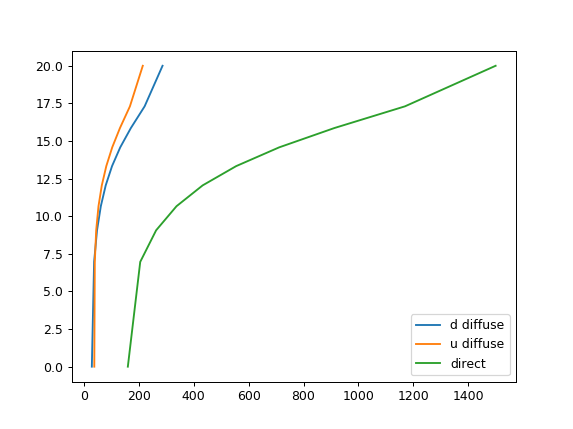

<IPython.core.display.Javascript object>


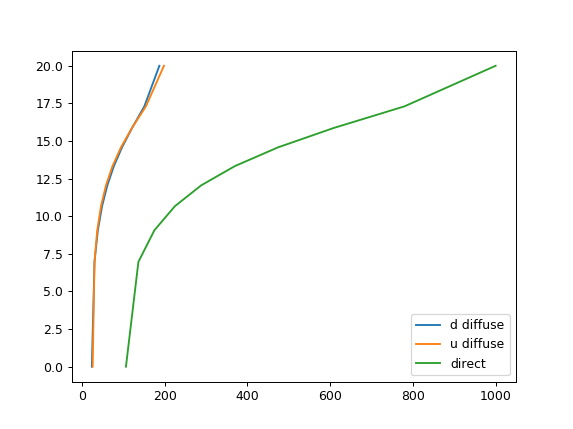

In [12]:
plt.figure()
plt.plot(m.I_df_d[0,:,0], m.z, label='d diffuse')
plt.plot(m.I_df_u[0,:,0], m.z, label='u diffuse')
plt.plot(m.I_dr[0,:,0], m.z, label='direct')
plt.legend()

plt.figure()
plt.plot(m.I_df_d[0,:,1], m.z, label='d diffuse')
plt.plot(m.I_df_u[0,:,1], m.z, label='u diffuse')
plt.plot(m.I_dr[0,:,1], m.z, label='direct')
plt.legend()



In [13]:
a = np.r_[24.98094031, 30.32748019, 35.33602132, 39.5968293, 42.44677123, 42.93421329,
          39.84533467, 31.89266291, 18.27245518,  0.        ]
a.sum()

305.6327084

In [14]:
m.I_df0_all

array([[1000,  100]])

In [15]:
m.I_df0 * m.dwl

array([300., 200.])